# To do:

 - Figure out how to signal injuries
 - Create model that generates minutes projections
 - Feature engineer a game count column, and optimize how many games you should be taken per dataset

In [127]:
import pandas as pd
import numpy as np
import duckdb
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
import warnings
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")
now = str(datetime.now().date())
print(f"Today's date:", now)

Today's date: 2025-12-08


# Feature Engineering

In [128]:
df = pd.DataFrame()
for i in [2024, 2025]:
    df_actuals = pd.read_csv(f"../tables/{i}/parlay_actuals.csv")
    df = pd.concat([df, df_actuals])

tgt_stat = "PTS"
df = df.sort_values(['Team', 'Player', 'Date'])

df['MP_L1'] = (
    df.groupby(['Team', 'Player'])['MP']
      .transform(lambda x: x.shift(1))
)

df['MP_L3'] = (
    df.groupby(['Team', 'Player'])['MP']
      .transform(lambda x: x.shift(1).rolling(3).mean())
)

df['MP_L5'] = (
    df.groupby(['Team', 'Player'])['MP']
      .transform(lambda x: x.shift(1).rolling(5).mean())
)
# df = df.dropna(subset='Opp')
# df = df[['Date', 'Team', 'B2B', 'Player', 'Pos', 'MP_L1', 'MP_L3', 'MP_L5', 'Opp', 
#          f'Off_{tgt_stat}', f'Off_L5_{tgt_stat}', f'AVG_{tgt_stat}_H2H', 
#          f'Def_{tgt_stat}', f'Def_L5_{tgt_stat}', f'{tgt_stat}_line',
#          f'{tgt_stat}_Hit_Pct', f'{tgt_stat}_P_Diff', 'Spread', 'Total', tgt_stat]]
final_cols = ['Date', 'Team', 'B2B', 'Player', 'Opp',
         f'Off_{tgt_stat}', f'Off_L5_{tgt_stat}', f'AVG_{tgt_stat}_H2H', 
         f'Def_{tgt_stat}', f'Def_L5_{tgt_stat}',
         tgt_stat]
df = df[final_cols]

df

,Date,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS
12941,01/03/2025,ATL,0,Bogdan Bogdanovic,LAL,8.150000,1.0,15.000000,14.065789,17.2,5
13713,01/07/2025,ATL,0,Bogdan Bogdanovic,UTA,7.909091,3.2,NaN,16.238806,9.8,11
14136,01/09/2025,ATL,0,Bogdan Bogdanovic,PHO,8.304348,6.6,NaN,14.158730,11.4,17
14949,01/14/2025,ATL,0,Bogdan Bogdanovic,PHO,8.333333,8.4,16.250000,13.971014,10.4,9
15164,01/15/2025,ATL,1,Bogdan Bogdanovic,CHI,8.120000,8.0,18.333333,12.621951,10.4,3
...,...,...,...,...,...,...,...,...,...,...,...
33196,04/13/2025,WAS,0,Tristan Vukcevic,MIA,7.173913,18.6,12.000000,13.210000,17.2,28
11228,12/23/2024,WAS,0,Tristan Vukcevic,OKC,0.000000,0.0,NaN,12.030303,12.8,0
11599,12/26/2024,WAS,0,Tristan Vukcevic,CHO,0.000000,0.0,NaN,12.900000,19.6,0
11979,12/28/2024,WAS,1,Tristan Vukcevic,NYK,0.000000,0.0,NaN,12.048780,16.4,0


# Baseline Model

In [129]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
n = len(df)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]

print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))

feature_cols = [col for col in df.columns 
                if col not in ['Date', tgt_stat]]

X_train, y_train = train_df[feature_cols], train_df[tgt_stat]
X_val,   y_val   = val_df[feature_cols],   val_df[tgt_stat]
X_test,  y_test  = test_df[feature_cols],  test_df[tgt_stat]


model = XGBRegressor(
    enable_categorical=True,
    n_estimators=300,    # number of trees
    learning_rate=0.05,  # step size
    max_depth=6,         # complexity
    subsample=0.8,       # row sampling
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

Train: 26088 / Validation: 5590 / Test: 5591
RMSE: 5.174531467623308
MAE: 3.7291619777679443
R²: 0.6793609857559204


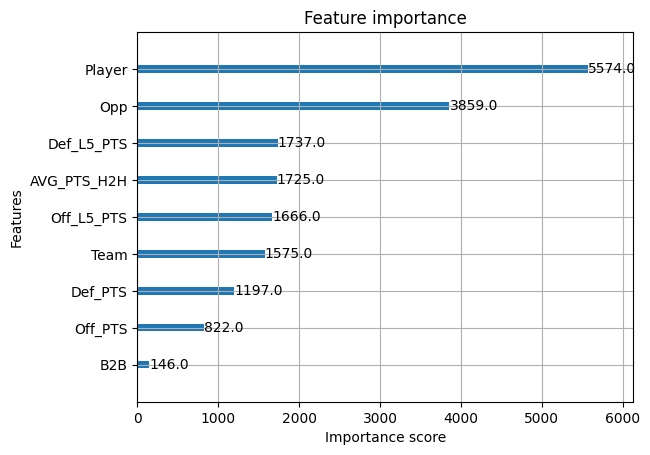

In [130]:
xgb.plot_importance(model)
plt.show()

# Hyperparameter tuning

In [131]:
param_dist = {
    "n_estimators": randint(200, 2000),
    "learning_rate": uniform(0.01, 0.3),
    "max_depth": randint(3, 10),
    "min_child_weight": randint(1, 10),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 5),
    "reg_lambda": uniform(0, 5),
    "reg_alpha": uniform(0, 5)
}


random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=40,                # increase to 80+ for better tuning
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_val, y_val)

best_model = random_search.best_estimator_
print("Best params:", random_search.best_params_, "\n")

preds = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_test, preds))
print("R²:", r2_score(y_test, preds))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params: {'colsample_bytree': np.float64(0.8493192507310232), 'gamma': np.float64(1.654490124263246), 'learning_rate': np.float64(0.02906750508580709), 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 1004, 'reg_alpha': np.float64(3.64803089169032), 'reg_lambda': np.float64(3.1877873567760657), 'subsample': np.float64(0.9548850970305306)} 

RMSE: 5.19927304395017
MAE: 3.741786479949951
R²: 0.6762874126434326


In [132]:
pred_col = f'{tgt_stat}_Pred'
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
test_df['Date'] = pd.to_datetime(test_df.Date)
df_lines = df_lines[['Date', 'Team', 'Player', f'{tgt_stat}_line']]
test_df[pred_col] = preds
df_test = test_df.merge(df_lines, on=['Date', 'Team', 'Player'])
df_test = df_test[[c for c in df_test.columns if c != pred_col] + [pred_col]]
df_test['Diff'] = abs(df_test[f'{tgt_stat}_Pred'] - df_test[f'{tgt_stat}_line'])
df_test['Act_Res'] = np.where(df_test[tgt_stat] > df_test[f'{tgt_stat}_line'], 'O', 'U')
df_test['Pred_Res'] = np.where(df_test[pred_col] > df_test[f'{tgt_stat}_line'], 'O', 'U')
df_test['Correct'] = np.where(df_test['Act_Res'] == df_test['Pred_Res'], 1, 0)

print("Total Accuracy:", ((df_test.Correct == 1).sum() / df_test.shape[0]))
print((df_test.Correct == 1).sum(), "/", df_test.shape[0])
display(df_test[df_test.Diff <= rmse].sort_values('Diff', ascending=False).drop(['Diff', 'Correct', 'Act_Res', 'Pred_Res'], axis=1).head(15))

Total Accuracy: 0.5167597765363129
370 / 716


,Date,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS,PTS_line,PTS_Pred
3,2025-11-30,LAL,1,Luka Doncic,NOP,35.142857,37.8,26.833333,19.888889,17.2,34,34.5,29.311346
68,2025-12-01,HOU,1,Reed Sheppard,UTA,14.250000,17.2,6.750000,22.529412,24.0,9,15.5,10.317429
4,2025-11-30,PHI,0,Joel Embiid,ATL,19.666667,22.8,NaN,14.214286,17.4,18,17.5,22.671749
96,2025-12-01,LAC,0,Kawhi Leonard,MIA,25.400000,27.0,20.500000,17.555556,14.4,36,22.5,27.604614
648,2025-12-06,HOU,1,Kevin Durant,DAL,25.294118,24.4,23.125000,16.133333,15.8,27,26.5,21.414579
686,2025-12-06,SAC,0,Zach LaVine,MIA,19.800000,15.0,NaN,16.320000,11.4,42,19.5,14.418717
70,2025-12-01,IND,1,Andrew Nembhard,CLE,17.166667,16.6,11.857143,19.000000,25.6,21,15.5,20.568481
102,2025-12-01,UTA,1,Lauri Markkanen,HOU,28.550000,20.4,NaN,19.818182,15.4,29,24.5,19.473541
482,2025-12-05,HOU,0,Kevin Durant,PHO,25.125000,22.8,NaN,15.062500,14.2,28,25.5,20.485113
222,2025-12-03,IND,0,Isaiah Jackson,DEN,8.650000,9.4,NaN,16.666667,19.6,6,7.5,12.480369


# Today's predictions

In [139]:
df_pred = pd.read_csv("../tables/2025/parlay_stats.csv")
df_pred['Date'] = pd.to_datetime(df_pred.Date)
for col in df_pred.select_dtypes(include='object').columns:
    df_pred[col] = df_pred[col].astype('category')
    
# Filter → then select feature columns
df_pred = df_pred[df_pred.Date == now][feature_cols]

# Predict
df_pred[f"{tgt_stat}_proj"] = best_model.predict(df_pred)
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[df_lines.Date == now][['Team', 'Player', f'{tgt_stat}_line']]
df_pred = df_pred.merge(df_lines, on=['Team', 'Player'])
df_pred['Diff'] = abs(df_pred[f'{tgt_stat}_proj'] - df_pred[f'{tgt_stat}_line'])

# print('Safe Bets')
# display(df_pred[(df_pred.Diff >= rmse)].drop('Diff', axis=1).sort_values('Team'))

print('Full')
for tm in df_pred.Team.unique():
    display(df_pred[(df_pred.Team == tm)].drop('Diff', axis=1))

Full


,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS_proj,PTS_line
0,DEN,0,Jamal Murray,CHO,24.619048,29.2,24.750000,21.590909,27.4,29.839520,24.5
22,DEN,0,Tim Hardaway Jr.,CHO,12.136364,15.8,10.833333,16.750000,17.4,11.343453,12.5
23,DEN,0,Bruce Brown,CHO,7.333333,8.2,7.000000,16.750000,17.4,6.222838,7.5
31,DEN,0,Peyton Watson,CHO,11.350000,12.2,NaN,19.736842,19.0,14.430992,12.5
32,DEN,0,Cameron Johnson,CHO,11.850000,15.6,NaN,19.736842,19.0,21.475924,14.5
62,DEN,0,Nikola Jokic,CHO,29.227273,28.0,22.000000,16.937500,17.6,25.085226,29.5
63,DEN,0,Jonas Valanciunas,CHO,8.181818,7.6,11.285714,16.937500,17.6,6.276014,8.5


,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS_proj,PTS_line
1,CHI,1,Josh Giddey,GSW,20.400000,20.2,14.000000,21.423077,22.6,14.200222,19.5
24,CHI,1,Ayo Dosunmu,GSW,15.789474,16.4,10.750000,15.521739,15.6,12.596460,13.5
25,CHI,1,Coby White,GSW,23.833333,23.2,NaN,15.521739,15.6,19.741596,19.5
50,CHI,1,Matas Buzelis,GSW,13.863636,14.0,NaN,17.315789,19.2,12.857928,14.5
51,CHI,1,Patrick Williams,GSW,7.380952,6.4,NaN,17.315789,19.2,8.123639,7.5
57,CHI,1,Nikola Vucevic,GSW,16.190476,14.6,16.500000,19.230769,20.2,12.800738,15.5
58,CHI,1,Zach Collins,GSW,8.000000,8.0,6.333333,19.230769,20.2,8.593446,6.5


,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS_proj,PTS_line
2,LAL,0,Luka Doncic,PHI,35.250000,36.6,NaN,19.058824,21.4,35.186695,31.5
3,LAL,0,Gabe Vincent,PHI,5.800000,7.6,NaN,19.058824,21.4,6.656327,4.5
17,LAL,0,Austin Reaves,PHI,29.315789,33.4,14.75,18.000000,17.2,26.837719,23.5
33,LAL,0,LeBron James,PHI,14.000000,14.6,22.50,19.285714,19.2,16.566776,17.5
55,LAL,0,Rui Hachimura,PHI,14.550000,13.2,NaN,16.833333,16.4,15.046910,11.5
56,LAL,0,Jake LaRavia,PHI,9.523810,7.2,NaN,16.833333,16.4,7.562180,4.5
66,LAL,0,Deandre Ayton,PHI,15.350000,14.8,NaN,15.785714,11.2,14.003863,13.5


,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS_proj,PTS_line
4,PHI,0,Tyrese Maxey,LAL,31.636364,29.6,NaN,18.227273,17.8,32.521545,27.5
18,PHI,0,Quentin Grimes,LAL,17.000000,17.8,NaN,17.461538,15.2,23.178022,13.5
19,PHI,0,Jared McCain,LAL,10.777778,10.8,NaN,17.461538,15.2,19.089281,9.5
20,PHI,0,VJ Edgecombe,LAL,14.315789,10.0,NaN,17.461538,15.2,10.490044,10.5
30,PHI,0,Justin Edwards,LAL,7.687500,8.2,NaN,20.947368,22.2,8.823784,3.5
44,PHI,0,Paul George,LAL,14.428571,14.2,20.75,19.954545,19.0,12.914873,13.5
69,PHI,0,Joel Embiid,LAL,18.500000,19.8,NaN,10.866667,11.8,15.083615,17.5


,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS_proj,PTS_line
5,UTA,0,Keyonte George,OKC,23.727273,26.8,15.666667,15.312500,17.6,22.784931,21.5
6,UTA,0,Isaiah Collier,OKC,8.066667,6.0,5.000000,15.312500,17.6,4.891298,5.5
35,UTA,0,Ace Bailey,OKC,11.090909,11.0,NaN,18.166667,16.6,12.185457,12.5
36,UTA,0,Svi Mykhailiuk,OKC,10.050000,8.6,6.428571,18.166667,16.6,6.014459,8.5
37,UTA,0,Brice Sensabaugh,OKC,9.333333,9.4,7.000000,18.166667,16.6,10.079660,8.5
52,UTA,0,Lauri Markkanen,OKC,28.173913,24.6,18.833333,17.250000,14.0,20.214230,23.5
70,UTA,0,Kyle Filipowski,OKC,9.045455,11.4,9.000000,10.600000,10.6,8.474449,11.5
71,UTA,0,Jusuf Nurkic,OKC,8.318182,10.6,5.285714,10.600000,10.6,6.886425,9.5


,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS_proj,PTS_line
7,OKC,0,Cason Wallace,UTA,8.285714,8.2,8.777778,21.0,22.6,9.593904,10.5
8,OKC,0,Jalen Williams,UTA,16.000000,16.0,22.428571,21.0,22.6,16.940998,23.5
9,OKC,0,Ajay Mitchell,UTA,15.380952,13.8,NaN,21.0,22.6,11.587716,17.5
10,OKC,0,Aaron Wiggins,UTA,13.636364,13.2,11.875000,21.0,22.6,11.165800,15.5
48,OKC,0,Chet Holmgren,UTA,17.666667,18.0,19.833333,17.5,17.8,13.934450,19.5
49,OKC,0,Kenrich Williams,UTA,6.500000,6.5,5.000000,17.5,17.8,9.010880,6.5


,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS_proj,PTS_line
11,MEM,0,Jaylen Wells,POR,12.000000,18.0,NaN,19.619048,20.6,11.345633,12.5
12,MEM,0,Kentavious Caldwell-Pope,POR,7.952381,8.0,10.000000,19.619048,20.6,8.612664,5.5
13,MEM,0,Cedric Coward,POR,13.434783,12.2,NaN,19.619048,20.6,11.523737,13.5
14,MEM,0,Vince Williams Jr.,POR,8.470588,7.6,6.600000,19.619048,20.6,7.711696,9.5
15,MEM,0,Cam Spencer,POR,11.043478,15.0,NaN,19.619048,20.6,13.696690,11.5
45,MEM,0,Santi Aldama,POR,12.739130,9.0,13.166667,18.526316,18.6,13.311897,11.5
59,MEM,0,Jock Landale,POR,10.739130,9.0,8.333333,18.600000,16.8,10.298404,8.5
60,MEM,0,Zach Edey,POR,13.800000,17.4,NaN,18.600000,16.8,15.509045,14.5
61,MEM,0,Jaren Jackson Jr.,POR,17.523810,16.8,18.666667,18.600000,16.8,16.668798,20.5


,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS_proj,PTS_line
16,CHO,0,Sion James,DEN,6.863636,6.00,NaN,19.235294,22.6,8.186995,6.5
40,CHO,0,Kon Knueppel,DEN,18.217391,16.80,NaN,16.666667,17.4,20.836502,18.5
41,CHO,0,Brandon Miller,DEN,16.285714,17.00,NaN,16.666667,17.4,22.187931,21.5
46,CHO,0,Miles Bridges,DEN,20.826087,17.60,27.0,17.600000,17.0,22.168154,21.5
47,CHO,0,Tidjane Salaun,DEN,8.250000,9.80,NaN,17.600000,17.0,11.193658,7.5
64,CHO,0,Ryan Kalkbrenner,DEN,9.095238,8.40,NaN,16.384615,16.2,11.712541,8.5
65,CHO,0,Mason Plumlee,DEN,3.250000,3.25,6.2,16.384615,16.2,5.321107,5.5


,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS_proj,PTS_line
21,POR,0,Shaedon Sharpe,MEM,21.315789,17.8,13.166667,17.125000,14.8,14.356297,22.5
38,POR,0,Deni Avdija,MEM,26.217391,31.0,14.800000,17.851852,19.8,23.966858,25.5
39,POR,0,Kris Murray,MEM,6.555556,7.4,2.857143,17.851852,19.8,7.844797,6.5
53,POR,0,Toumani Camara,MEM,12.391304,13.6,9.428571,17.050000,16.4,12.782044,13.5
54,POR,0,Jerami Grant,MEM,19.409091,19.0,14.142857,17.050000,16.4,15.146699,18.5
67,POR,0,Yang Hansen,MEM,3.333333,4.6,NaN,14.923077,9.2,6.127194,7.5
68,POR,0,Duop Reath,MEM,5.545455,4.6,9.600000,14.923077,9.2,7.226113,6.5


,Team,B2B,Player,Opp,Off_PTS,Off_L5_PTS,AVG_PTS_H2H,Def_PTS,Def_L5_PTS,PTS_proj,PTS_line
26,GSW,1,Buddy Hield,CHI,9.142857,13.6,11.75,15.466667,22.0,16.258619,11.5
27,GSW,1,Brandin Podziemski,CHI,12.166667,12.4,10.50,15.466667,22.0,15.733289,9.5
28,GSW,1,Moses Moody,CHI,12.238095,9.2,NaN,15.466667,22.0,15.177197,8.5
29,GSW,1,Will Richard,CHI,8.285714,7.0,NaN,15.466667,22.0,8.062893,7.5
34,GSW,1,Jimmy Butler,CHI,19.500000,17.8,19.00,18.269231,23.4,19.413311,20.5
42,GSW,1,Quinten Post,CHI,8.684211,9.0,NaN,23.684211,26.2,9.471409,10.5
43,GSW,1,Jonathan Kuminga,CHI,13.125000,8.8,NaN,23.684211,26.2,11.428696,11.5
